<a href="https://colab.research.google.com/github/visu27/image-captioning/blob/master/image_cap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package libfuse2:amd64.
(Reading database ... 22280 files and directories currently installed.)
Preparing to unpack .../libfuse2_2.9.7-1ubuntu1_amd64.deb ...
Unpacking libfuse2:amd64 (2.9.7-1ubuntu1) ...
Selecting previously unselected package fuse.
Preparing to unpack .../fuse_2.9.7-1ubuntu1_amd64.deb ...
Unpacking fuse (2.9.7-1ubuntu1) ...
Selecting previously unselected package google-drive-ocamlfuse.
Preparing to unpack .../google-drive-ocamlfuse_0.7.0-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.0-0ubuntu1~ubuntu18.04.1) ...
Setting up libfuse2:amd64 (2.9.7-1ubuntu1) ...
Processing triggers for libc-bin (2.27-3ubuntu1) ...
Setting up fuse (2.9.7-1ubuntu1) ...
Setting up google-drive-ocamlfuse (0.7.0-0ubuntu1~ubuntu18.04.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleus

In [2]:
!mkdir -p drive
!google-drive-ocamlfuse drive
!ls

adc.json  drive  sample_data


In [3]:
import numpy as np
import os,pickle
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img,img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model, to_categorical
from keras.layers import Input,Dense
from keras.layers import Input, Embedding, Dense, LSTM, Dropout, add,GRU,Reshape,Lambda,BatchNormalization
from keras.models import load_model
from matplotlib.pyplot import imread, imshow
%matplotlib inline
import tensorflow as tf
from math import ceil
from  keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from nltk.translate.bleu_score import corpus_bleu,sentence_bleu
from time import time


Using TensorFlow backend.


In [0]:
def extract_features(directory):
	model = VGG16()
	model.layers.pop()
	model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
	features = dict()
	for name in os.listdir(directory):
		filename = directory + '/' + name
		image = load_img(filename, target_size=(224, 224))
		image = img_to_array(image)
		image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
		image = preprocess_input(image)
		feature = model.predict(image, verbose=0)
		image_id = name.split('.')[0]
		features[image_id] = feature
	return features
directory = 'drive/img_data/data/Flicker8k_Dataset'
features = extract_features(directory)
print('Extracted Features: %d' % len(features))
pickle.dump(features, open('features.pkl', 'wb'))

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth) 
file = drive.CreateFile({'title': 'features.pkl'})
file.SetContentFile('features.pkl')
file.Upload()

In [6]:
train_filename= 'drive/img_data/text/Flickr_8k.trainImages.txt'
val_filename= 'drive/img_data/text/Flickr_8k.devImages.txt'
image_filename='drive/img_data/features.pkl'
def load_descriptions(filename): 
    map_to_text= {}
    data= open(filename,'r').read()
    for line in data.split('\n'):
        tokens = line.split()
        if(len(tokens)<2):
            continue
        image_id , image_desc = tokens[0], tokens[1:]
        desc = [t.lower() for t in image_desc if(len(t)>1) and t.isalpha()]
        image_desc = 'startseq '+' '.join(desc)+' endseq'
        image_id= image_id.split('.')[0]
        if image_id not in map_to_text:
            map_to_text[image_id]=list()
        map_to_text[image_id].append(image_desc)
    return map_to_text
map_to_text= load_descriptions('drive/img_data/text/Flickr8k.token.txt')
print(len(map_to_text))

8092


In [7]:
def extract_vocab(map_to_text):
    vocab=set()
    for key,values in map_to_text.items():
        for value in values:
            vocab.update(value.split())
    return vocab
vocab= extract_vocab(map_to_text)        
print(len(vocab))

8359


In [8]:
def load_ids(filename):
    data= open(filename,'r')
    ids=[]
    for image in data.readlines():
        ids.append(image.split('.')[0])
    return ids
def load_descriptions(map_to_text,ids): 
    data= {}
    for key,value in map_to_text.items():
        if key in ids:
            data[key]=value
    return data
def load_image_features(filename,ids):
    features_dict= pickle.load(open(filename,'rb'))
    data={}
    for key,value in features_dict.items():
        if key in ids:
            data[key]=value
    return data
def  create_tokenizer(descriptions):
    data=[]
    for key,values in descriptions.items():
        [data.append(value) for value in values]
    token=Tokenizer()
    token.fit_on_texts(data)
    return token
train_ids = load_ids(train_filename)
val_ids = load_ids(val_filename)
train_desc = load_descriptions(map_to_text,train_ids)
val_desc = load_descriptions(map_to_text,val_ids)
train_img= load_image_features(image_filename,train_ids)
val_img= load_image_features(image_filename,val_ids)
tokenizer= create_tokenizer(train_desc)
vocab_size=len(tokenizer.word_index)+1
print(vocab_size)
def max_length(descriptions):
    data=[]
    for key,values in descriptions.items():
        [data.append(value) for value in values]
    return max(len(d.split()) for d in data)
max_len = max(max_length(train_desc),max_length(val_desc))

7266


In [0]:

def create_sequences(tokenizer, max_length, desc_list, photo):
	X1, X2, y = list(), list(), list()
	for desc in desc_list:
		seq = tokenizer.texts_to_sequences([desc])[0]
		for i in range(1, len(seq)):
			in_seq, out_seq = seq[:i], seq[i]
			in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
			out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
			X1.append(photo)
			X2.append(in_seq)
			y.append(out_seq)
	return np.array(X1), np.array(X2), np.array(y)


def gen_model(vocab_size, seq_length):
    inputs1 = Input(shape=(4096,))
    fe1 = Dense(256, activation='relu')(inputs1)
    fe2 = Dropout(0.5)(fe1)
    inputs2 = Input(shape=(seq_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model
def data_generator(descriptions, photos, tokenizer, max_length):
    while 1:
      for key, desc_list in descriptions.items():
        photo = photos[key][0]
        in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_list, photo)
        yield [[in_img, in_seq], out_word]
model=gen_model(vocab_size,max_len)
filepath = 'drive/img_data/final_lstmimagecaption3layers_img_hidd-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True, mode='min')
epochs = 20
steps = len(train_desc)
val_steps = len(val_desc)
for i in range(epochs):
    generator = data_generator(train_desc, train_img, tokenizer, max_len)
    val_generator= data_generator(val_desc,val_img,tokenizer,max_len)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps,callbacks=[checkpoint], verbose=1,validation_data=val_generator, validation_steps=val_steps)
    print(str(i+1 )+' epochs Finished'+' out of '+ str(epochs) )
    model.save('model_' + str(i) + '.h5')
model.save('drive/img_data/final_lstm3_imglstm_img_hidd_final.h5')

Epoch 1/1
6000/6000 [==============================] - 701s 117ms/step - loss: 4.7360 - val_loss: 4.2467
1 epochs Finished out of 20
Epoch 1/1
6000/6000 [==============================] - 702s 117ms/step - loss: 4.0312 - val_loss: 4.0325
2 epochs Finished out of 20
Epoch 1/1
6000/6000 [==============================] - 700s 117ms/step - loss: 3.7862 - val_loss: 3.9740
3 epochs Finished out of 20
Epoch 1/1
6000/6000 [==============================] - 698s 116ms/step - loss: 3.6367 - val_loss: 3.9540
4 epochs Finished out of 20
Epoch 1/1
6000/6000 [==============================] - 695s 116ms/step - loss: 3.5378 - val_loss: 3.9426
5 epochs Finished out of 20
Epoch 1/1
6000/6000 [==============================] - 698s 116ms/step - loss: 3.4661 - val_loss: 3.9407
6 epochs Finished out of 20
Epoch 1/1
6000/6000 [==============================] - 698s 116ms/step - loss: 3.4077 - val_loss: 3.9575
7 epochs Finished out of 20
Epoch 1/1
6000/6000 [==============================] - 695s 116ms/ste

In [17]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
def generate_desc(model, tokenizer, photo, max_length):
  in_text = 'startseq'
  for i in range(max_length):
    sequence = tokenizer.texts_to_sequences([in_text])[0]
    sequence = pad_sequences([sequence], maxlen=max_length)
    yhat = model.predict([photo,sequence], verbose=0)
    yhat = np.argmax(yhat)
    word = word_for_id(yhat, tokenizer)
    if word is None:
      break
    in_text += ' ' + word
    if word == 'endseq':
      break
  return in_text
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
  actual, predicted = list(), list()
  for key, desc_list in descriptions.items():
    yhat = generate_desc(model, tokenizer, photos[key], max_length)
    references = [d.split() for d in desc_list]
    actual.append(references)
    predicted.append(yhat.split())
  print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
  print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
  print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
  print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
f1='drive/img_data/final_lstm3_imglstm_img_hidd_final2.h5'
model = load_model(f1)
evaluate_model(model, val_desc, val_img, tokenizer, max_len)


BLEU-1: 0.477018
BLEU-2: 0.241297
BLEU-3: 0.161354
BLEU-4: 0.069397


In [12]:
index_word= dict(map(reversed, tokenizer.word_index.items()))
def beam_search_predict_captions(img,tokenizer,max_len=33,beam_width=3):
    start= 'startseq'
    count_tokens=0
    token_input= np.zeros((1,33))
    z= np.zeros((1,512))
    token_input[0,count_tokens]= 1
    beam_outputs=[[token_input,-10.0]]
    while count_tokens<max_len-1 : 
      tmp=[]
      for i in beam_outputs:
        x,score = i
        #print(x)
        #print(x.shape)
        #x= np.reshape(1,1,33)
        #x1 = pad_sequences([x],max_len,padding='post')[0]
        outputs = model.predict([np.array(img),np.array(x),z])
        out = np.array(outputs[count_tokens][0].ravel())
        top_beam = np.argsort(out)[-beam_width:]
        #print(top_beam)
        for p in top_beam:
          #print(p)
          x1=np.copy(x)
          x1[0,count_tokens+1]= p
          #print(x1)
          new_score= ((count_tokens*score+ np.log(out[p])))/(count_tokens+1)
          #new_score= score+ np.log(out[p])
          #print(new_score)
          tmp.append([x1,new_score])
          #print(tmp)
      #print(tmp)
      #beam_outputs.extend(tmp)
      #print(len(beam_outputs))
      beam_outputs=tmp
      beam_outputs=sorted(beam_outputs,key= lambda x : x[1],reverse=True)
      beam_outputs = beam_outputs[0:beam_width]
      #print((beam_outputs))
      count_tokens = count_tokens+1
    beam_outputs=sorted(beam_outputs,key= lambda x : x[1],reverse=True)
    ans= beam_outputs[0][0].ravel()
    #print(ans)
    sentence=[]
    for out in ans:
        string= index_word[out]
        sentence+= [string]
        if string=='endseq':
            break
    return sentence
def evaluate_model(model ,descriptions, features, tokenizer,beam_width):
    actual, predicted = list(), list()
    samples = len(descriptions.items())
    for key, desc_list in descriptions.items():
        prediction = beam_search_predict_captions(features[key],tokenizer,beam_width=beam_width)
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(prediction)
        #print(prediction)
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))
f='drive/img_data/final_lstm3_imglstm_img_hidd_final.h5'
model = load_model(f)
evaluate_model(model, val_desc, val_img, tokenizer, 3)

BLEU-1: 0.415955
BLEU-2: 0.192152
BLEU-3: 0.095778
BLEU-4: 0.023780


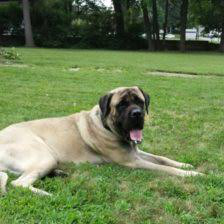

In [22]:
from PIL import Image
Image.open('drive/download.jpg')

In [19]:
def extract_features(filename):
	model = VGG16()
	model.layers.pop()
	model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
	image = load_img(filename, target_size=(224, 224))
	image = img_to_array(image)
	image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
	image = preprocess_input(image)
	feature = model.predict(image, verbose=0)
	return feature

photo = extract_features('drive/download.jpg')
#desc=beam_search_predict_captions(photo,tokenizer,3)
desc=generate_desc(model, tokenizer, photo, max_len)
print(desc)

startseq dog is running through the grass with its tongue hanging out endseq
